# Extracting wake and filtering it out of data

Restarting from the downsampled xrarray, extraction of active (without SWR) and quiet wake (with SWR) periods and removing these periods from the recordings.

## Load EMG and packages

In [4]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
import mmap
from pathlib import Path

%matplotlib widget

# mmap activated to not store everything in memory

"""def other_mmap(filename, shape, dtype, chunks):
    with open(filename, "rb") as fh:
        # `mmap` duplicates the file descriptor
        # `0` means map the full file
        mm = mmap.mmap(fh.fileno(), 0, access=mmap.ACCESS_READ)

    # coerce to NumPy array of expected type and shape
    a = np.asarray(mm).view(dtype).reshape(shape)

    # Don't call `asarray`
    # name=False to avoid hashing
    a_d = da.from_array(a, chunks=chunks, asarray=False, name=False)
    return a_d"""

folder_base = Path('C:/Users/AudreyHay/Desktop/fusion 20 février python')
#folder_base = Path('/mnt/data/ahay/')
filename = folder_base / f'RawDataChannelExtractedDS2.npy'
All = np.load(filename, mmap_mode= 'r')
All = All.T
EMG = All[:,22] #Femelle: 58 - 32 = 26 // 0 based : 26-1 = 25 /// Mâle: 0 based uniquement



## High pass filter

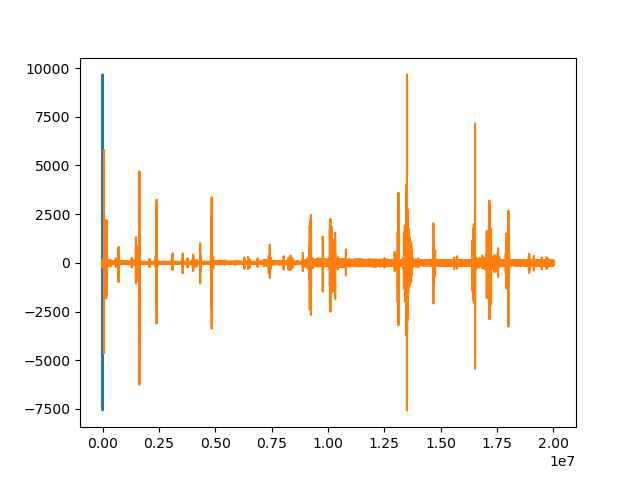

In [5]:
# Filter parameter :
f_lowcut = 200.
f_hicut = 400.
N = 4
fs = 1000
nyq = 0.5 * fs
Wn = [f_lowcut/nyq,f_hicut/nyq]  # Nyquist frequency fraction


# Filter creation :
b, a = signal.butter(N, Wn, 'band')
filt_EMG = signal.filtfilt(b, a, EMG)

# Plot
times = np.arange(0, EMG.size/fs, 1./fs)
timesmin = np.arange(0, EMG.size/fs/60, 1./fs/60)

fig, ax = plt.subplots()
ax.plot(timesmin, filt_EMG)
#ax.plot(timesmin[:2000*fs], filt_EMG[:2000*fs])

plt.plot(filt_EMG[:20000*fs])
#plt.show()

## Continuous Wavelet Transform and projection calculation

In [6]:
# Parameter and computation of CWT
w = 4.
freq = np.linspace(200, 400, 50)
widths = w*fs / (2*freq*np.pi)
EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)

# Projection calculation
absEMGcwt = np.absolute(EMGcwt)
proj_EMGcwt = np.sum(absEMGcwt, axis = 0)/50
sdproj_EMGcwt = np.std(proj_EMGcwt)
sd3proj_EMGcwt = sdproj_EMGcwt*40
sd05proj_EMGcwt = sdproj_EMGcwt*15



C:\Users\AudreyHay\AppData\Local\Temp\ipykernel_19292\1445604021.py:5: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  EMGcwt = signal.cwt(EMG, signal.morlet2, widths, w=w)


### Display subset 

Not necessary cell to run

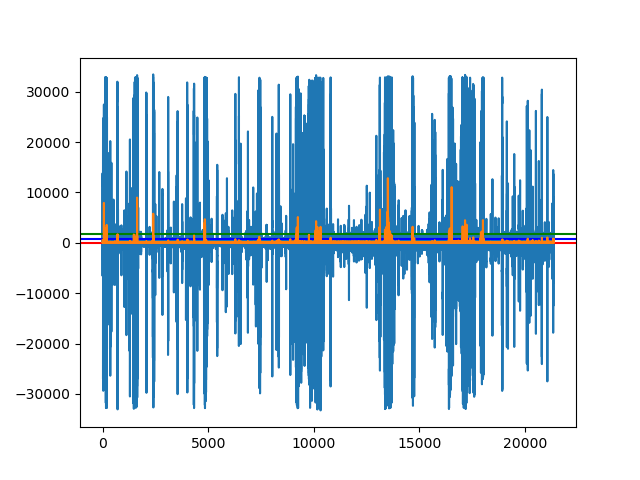

In [7]:
# Defining subset

#echantillon de 10 secondes (voir les 3 lignes) sample_size = 10000
#start =  np.random.randint(0, EMG.size - sample_size)
#end = start + sample_size
# Defining subset
start = 00000
end = 100000000

tt = times[start:end]
EMGt = EMG[start:end]
EMGcwtt = EMGcwt[:, start:end]
proj_EMGcwtt = proj_EMGcwt[start:end]

plt.figure()
plt.plot(tt, EMGt)
plt.axhline(sdproj_EMGcwt, color='r') # horizontal
plt.axhline(sd3proj_EMGcwt, color='g') # horizontal
plt.axhline(sd05proj_EMGcwt, color='b') # horizontal
plt.plot(tt, proj_EMGcwtt)
plt.show()

## WARNING: Plot only short subsets (~ 10 s), too memory consuming otherwise
#plt.pcolormesh(tt, freq, np.abs(EMGcwt), cmap='viridis', shading='gouraud')
#plt.plot(tt, EMGt)
#plt.show()


In [8]:
plt.close('all')


## Interpretating signal to extract wake (active and quiet) and sleep

In [10]:
# Assigning values wake (1, 2) and sleep (0)
# 1 = eveil calme // 2 = eveil énergique
numpnts = EMG.size
EMGstatusRaw = np.zeros(numpnts)
for ind in range(numpnts):
    if proj_EMGcwt[ind]<sd05proj_EMGcwt:
        EMGstatusRaw[ind] = 0
    elif proj_EMGcwt[ind]>sd3proj_EMGcwt:
        EMGstatusRaw[ind] = 2
    else: 
        EMGstatusRaw[ind] = 1

# Expanding borders for wake (1, 2) and sleep (0) to ±1 s around detected muscular activity
EMGstatusRaw2 = np.zeros(numpnts)
for ind in range(numpnts):
    if EMGstatusRaw[ind]>1:
       EMGstatusRaw2[ind-1000:ind+1000] = 2
    elif EMGstatusRaw[ind]==1:
        for ind2 in range(ind-1000, ind+1000):
            if ind2==numpnts:
                break
            elif EMGstatusRaw2[ind2]<2:
                EMGstatusRaw2[ind2] = 1

Nombre de transitions de 0 à 1 : 127
Nombre de transitions de 1 à 2 : 58
Nombre de transitions de 2 à 1 : 58
Nombre de transitions de 1 à 0 : 126
Durée de l'état 0 : 20875040 ms
Durée de l'état 1 : 286869 ms
Durée de l'état 2 : 177867 ms


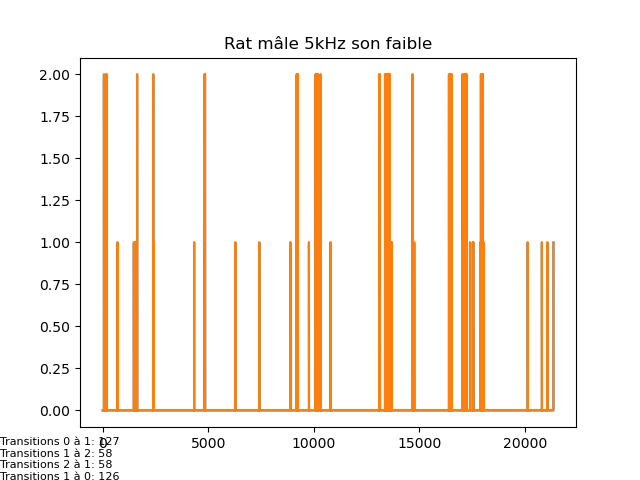

In [11]:
# Redimensionner EMGstatusRaw_resized et EMGstatusRaw2 à la même longueur que tt
#EMGstatusRaw_resized = np.resize(EMGstatusRaw_resized, tt.shape)
#EMGstatusRaw2 = np.resize(EMGstatusRaw2, tt.shape)

#if needed, plot of the two layers of filters
#plt.close('all')

# Now you can plot both arrays
#plt.plot(tt, EMGstatusRaw_resized)
#plt.plot(tt, EMGstatusRaw2)
#plt.show()

# if needed, plot of the two layers of filters

transitions_0_to_1 = 0
transitions_1_to_2 = 0
transitions_2_to_1 = 0
transitions_1_to_0 = 0

# Compter les transitions
for i in range(1, len(EMGstatusRaw2)):
    if EMGstatusRaw2[i-1] == 0 and EMGstatusRaw2[i] == 1:
        transitions_0_to_1 += 1
    elif EMGstatusRaw2[i-1] == 1 and EMGstatusRaw2[i] == 2:
        transitions_1_to_2 += 1
    elif EMGstatusRaw2[i-1] == 2 and EMGstatusRaw2[i] == 1:
        transitions_2_to_1 += 1
    elif EMGstatusRaw2[i-1] == 1 and EMGstatusRaw2[i] == 0:
        transitions_1_to_0 += 1

# Afficher les résultats
print("Nombre de transitions de 0 à 1 :", transitions_0_to_1)
print("Nombre de transitions de 1 à 2 :", transitions_1_to_2)
print("Nombre de transitions de 2 à 1 :", transitions_2_to_1)
print("Nombre de transitions de 1 à 0 :", transitions_1_to_0)
#0 = sommeil // 1 = éveil très calme // 2 = éveil énergique

# Calcul de la durée des états
duree_etat_0 = np.sum(EMGstatusRaw2 == 0)
duree_etat_1 = np.sum(EMGstatusRaw2 == 1)
duree_etat_2 = np.sum(EMGstatusRaw2 == 2)

# Affichage des durées
print("Durée de l'état 0 :", duree_etat_0, "ms")
print("Durée de l'état 1 :", duree_etat_1, "ms")
print("Durée de l'état 2 :", duree_etat_2, "ms")

plt.close('all')
plt.plot(tt, EMGstatusRaw)
plt.plot(tt, EMGstatusRaw2)
plt.title('Rat mâle 5kHz son faible')
plt.figtext(0, 0, f"Transitions 0 à 1: {transitions_0_to_1}\nTransitions 1 à 2: {transitions_1_to_2}\nTransitions 2 à 1: {transitions_2_to_1}\nTransitions 1 à 0: {transitions_1_to_0}", fontsize=8, horizontalalignment='left')
plt.show()


In [12]:
plt.close()

## To Create boolean masks and to save recordings without movement
#### Creating two masks: one conservative excludes weak muscular activity that can be quiet wake or dozing and one liberal that includes weak muscular activity

In [ ]:
EMGStatusBoolLib = (EMGstatusRaw2>1)
EMGStatusBoolCons = (EMGstatusRaw2>0)


No such comm: 9fcf5c60c3f6447a89c833c43c0527b8


No such comm: b05e0fdec2a54c4eb7f6f13d00446e56


: 

#### Removing wake time from the recordings.
Two files created one with 0 instead of signal during wake and one with the wake time removed

In [ ]:
print(f"EMGStatusBoolLib length: {EMGStatusBoolLib.shape[0]}")

LFP = All[:, 1:32]
LFPwake0 = LFP.copy()
LFPwake0[EMGStatusBoolLib] = 0
np.save('LFPwake0.npy', LFPwake0)

LFPwakeremoved = LFP.copy()
LFPwakeremoved = LFPwakeremoved[~EMGStatusBoolLib, :]
np.save('LFPwakeremoved_2.npy', LFPwakeremoved)
print(f"LFPwake0 length: {LFPwake0.shape[0]}")
print(f"LFPwakeremoved length: {LFPwakeremoved.shape[0]}")

data = {
    'EMGstatus': EMGstatusRaw2,
    'BooleanLiberal' : EMGStatusBoolLib,
    'BooleanConservative' : EMGStatusBoolCons
}
WakeFrame = pd.DataFrame(data, columns=['EMGstatus', 'BooleanLiberal', 'BooleanConservative'])
WakeFrame.to_pickle('EMGframeBoolean_2.pkl')

# Obtenez les indices des valeurs True dans EMGStatusBoolLib
indices = np.where(EMGStatusBoolLib)

# Modifiez les valeurs correspondantes de LFPwake0 à l'aide des indices obtenus
LFPwake0[indices] = 0




EMGStatusBoolLib length: 21272960


KeyboardInterrupt: 

In [ ]:
WakeFrame

,EMGstatus,BooleanLiberal,BooleanConservative
0,0.0,False,False
1,0.0,False,False
2,0.0,False,False
3,0.0,False,False
4,0.0,False,False
...,...,...,...
21272955,0.0,False,False
21272956,0.0,False,False
21272957,0.0,False,False
21272958,0.0,False,False


(1000, 3)


ValueError: x and y must have same first dimension, but have shapes (0,) and (1000, 3)

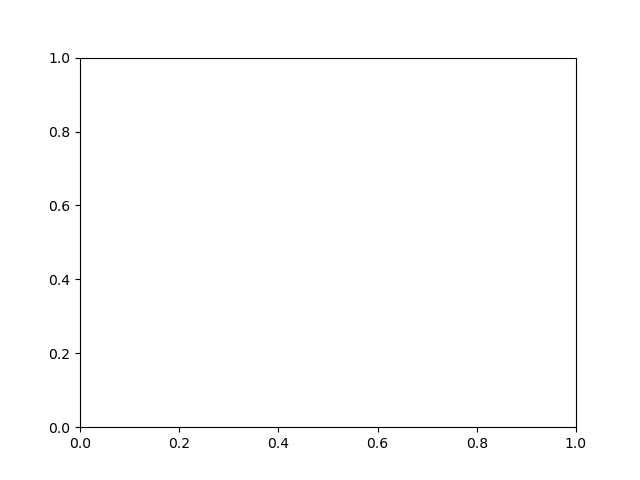

In [ ]:
# Display on a subset (not a necessary step)
start = 1000
end = 2000

LFP = All[start:end, 1:4]
EMGStatusBoolLibt = EMGStatusBoolLib[start:end]
tt2 = tt[start:end]
EMGstatusRaw3 = EMGstatusRaw2[start:end]*2000
tentative = LFP.copy()

# to display LFP with wake time kept but signal set at 0
#tentative[EMGStatusBoolLibt] = 0
#plt.close('all')
#plt.plot(tt2, tentative)
#plt.plot(tt2, EMGstatusRaw3)
#plt.show()

# to display LFP with wake time removed.
tentative = tentative[~EMGStatusBoolLibt, :]
print(tentative.shape)
tt3 = tt[start:tentative.shape[0]]
plt.close('all')
plt.plot(tt3, tentative)
plt.show()
